# Alternative credit scoring - Value-add of alternative data points

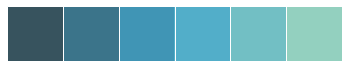

In [6]:
#Imports and settings
import pandas as pd
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import string
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from collections import Counter
%matplotlib inline
sns.palplot(sns.color_palette("GnBu_d"))
sns.set(rc={'figure.figsize':(20,7)})

# Data exploration and preparation

In [7]:
#Read in data on applicant records (ar), corresponding credit records (cr), and dictionary (d)
df_ar = pd.read_csv('Data/application_record.csv')
df_cr = pd.read_csv('Data/credit_record.csv')
df_d = pd.read_excel('Data/dictionary.xls')

In [8]:
#Review what variables mean based on dictionary
df_d

,Type,Feature name,Explanation,Remarks
0,application_record,ID,client number,0
1,application_record,'CODE_GENDER',gender,0
2,application_record,'FLAGOWNCAR',Is there a car,0
3,application_record,'FLAGOWNREALTY',Is there a property,0
4,application_record,'CNT_CHILDREN',Number of children,0
5,application_record,'AMTINCOMETOTAL',Annual income,0
6,application_record,'NAMEINCOMETYPE',Income category,0
7,application_record,'NAMEEDUCATIONTYPE',education level,0
8,application_record,'NAMEFAMILYSTATUS',Marital status,0
9,application_record,'NAMEHOUSINGTYPE',Way of living,0


In [9]:
#Review what credit record status corresponds to a default -> a '5' corresponds to default
df_d.loc[df_d['Feature name'] == 'STATUS']['Remarks'].item()

'0: 1-29 days past due 1: 30-59 days past due 2: 60-89 days overdue 3: 90-119 days overdue 4: 120-149 days overdue 5: Overdue or bad debts write-offs for more than 150 days C: paid off that month X: No loan for the month'

In [10]:
#Now we know that a '5' corresponds to a severely overdue credit or a bed debt write-off. 
#We can now engineer this feature and find out how many people defaulted on their products

df_cr['Count'] = [1 if x != 'X' else 0 for x in df_cr['STATUS']] #only count active loans

df_cr['Defaulted'] = [1 if x == '5' else 0 for x in df_cr['STATUS']]

df_cr_aggregated = df_cr.groupby('ID', as_index = False).sum()

default_rate = len(df_cr_aggregated.loc[df_cr_aggregated['Defaulted'] != 0]) / len(df_cr_aggregated)

print('The number of people with loan information is {}.'.format(len(df_cr_aggregated)))
print('The number of people who defaulted on their loan is {}.'.format(len(df_cr_aggregated.loc[df_cr_aggregated['Defaulted'] != 0])))
print('The share of people who defaulted on their loan is {}.'.format(default_rate))

The number of people with loan information is 45985.
The number of people who defaulted on their loan is 195.
The share of people who defaulted on their loan is 0.004240513210829618.


The number of customers who defaulted is quite small (0.4%) so I will create a subset that consists 10% of those customers and 90% of customers who successfully repaid their loans to simulate the real world. The 90% will be selected at random.

In [11]:
#Create random sample out of non-defaulted applicants and append defaulted applicants
df_subset = df_cr_aggregated.loc[df_cr_aggregated['Defaulted']==0].sample(9*195).append(df_cr_aggregated.loc[df_cr_aggregated['Defaulted'] != 0])

#Merge that information with applicant data
result = pd.merge(df_subset, df_ar, on=['ID'])
print(len(result))
result.head(10)

1580


,ID,MONTHS_BALANCE,Count,Defaulted,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5091120,-95,10,0,M,N,Y,1,292500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-14785,-3018,1,1,1,0,Laborers,3.0
1,5137003,-528,32,0,M,Y,N,0,139500.0,Working,Secondary / secondary special,Married,House / apartment,-18333,-8143,1,1,1,0,Drivers,2.0
2,5142390,-66,12,0,M,Y,Y,0,135000.0,Working,Academic degree,Married,House / apartment,-22541,-195,1,0,1,0,NaN,2.0
3,5053520,-1175,25,0,F,N,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-14762,-2464,1,0,1,0,Managers,2.0
4,5067864,-630,32,0,F,N,Y,0,144000.0,Working,Secondary / secondary special,Married,House / apartment,-18705,-5345,1,0,0,0,Medicine staff,2.0
5,5050857,-6,4,0,M,N,N,0,180000.0,Commercial associate,Higher education,Single / not married,House / apartment,-9488,-1505,1,0,0,0,High skill tech staff,1.0
6,5126829,-10,5,0,F,N,Y,0,153000.0,Pensioner,Secondary / secondary special,Single / not married,House / apartment,-22029,365243,1,0,0,1,NaN,1.0
7,5115513,-171,18,0,F,N,N,1,81000.0,Working,Secondary / secondary special,Married,With parents,-12812,-3389,1,1,1,0,Core staff,3.0
8,5089575,-741,38,0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,House / apartment,-11309,-2713,1,1,0,0,Sales staff,2.0
9,5024771,-120,14,0,F,Y,Y,0,202500.0,Working,Secondary / secondary special,Single / not married,House / apartment,-8568,-1068,1,0,0,0,Sales staff,1.0


In [12]:
#Some IDs could not be matched, hence we confirm that we still have a roughly 90% / 10% split in the data:
print('The number of people with loan information is {}.'.format(len(result)))
print('The number of people who defaulted on their loan is {}.'.format(len(result.loc[result['Defaulted'] != 0])))
print('The share of people who defaulted on their loan is {}.'.format(len(result.loc[result['Defaulted'] != 0])/len(result)))

The number of people with loan information is 1580.
The number of people who defaulted on their loan is 180.
The share of people who defaulted on their loan is 0.11392405063291139.


In [13]:
#We now get rid of unnecessary columns and make categorical values numeric

#Rename and drop irrelevant columns
result.columns = [x.lower() for x in result.columns.tolist()] #for easier typing
result.drop(labels = ['id', 'months_balance', 'count'], axis = 1, inplace=True)

#convert binary answers to numeric variables
result['defaulted'] = [1 if x != 0 else 0 for x in result['defaulted'].tolist()] 
result['code_gender'] = [1 if x == 'M' else 0 for x in result['code_gender'].tolist()] 
result['flag_own_car'] = [1 if x == 'Y' else 0 for x in result['flag_own_car'].tolist()] 
result['flag_own_realty'] = [1 if x == 'Y' else 0 for x in result['flag_own_realty'].tolist()] 

#We check whether there might be some categorical variables with too many possible values.
for i in result.columns:
    print([i])
    print(result[i].nunique())
    

['defaulted']
2
['code_gender']
2
['flag_own_car']
2
['flag_own_realty']
2
['cnt_children']
5
['amt_income_total']
113
['name_income_type']
5
['name_education_type']
5
['name_family_status']
5
['name_housing_type']
6
['days_birth']
1316
['days_employed']
944
['flag_mobil']
1
['flag_work_phone']
2
['flag_phone']
2
['flag_email']
2
['occupation_type']
18
['cnt_fam_members']
6


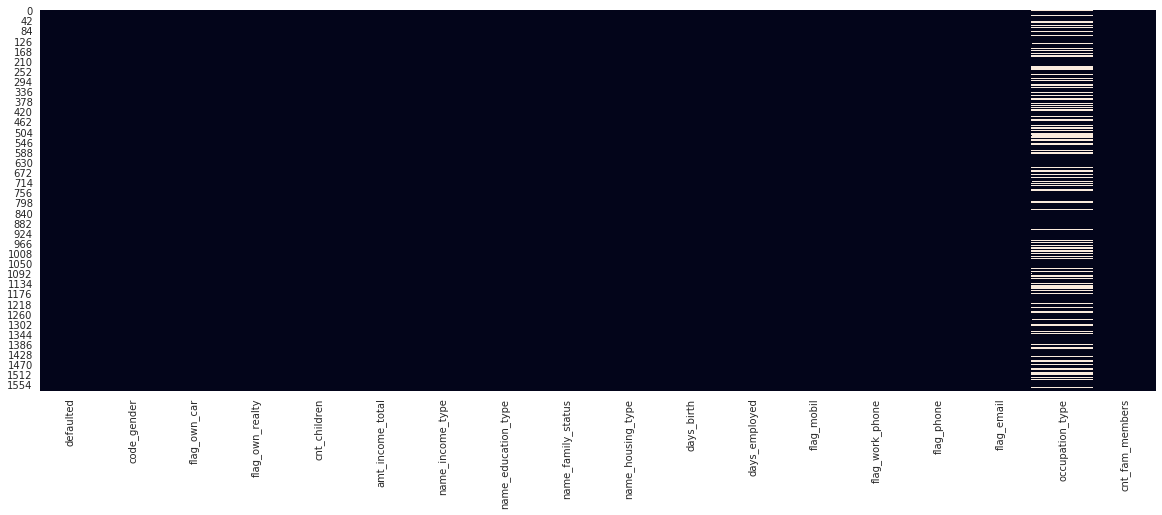

In [14]:
#check missing values for each variable
sns.heatmap(result.isnull(), cbar=False)

In [16]:
#Occupation_type has over 18 possible values, which seems a lot for our dataset. It also has over 400 nans, hence drop it.
result.drop('occupation_type', axis = 1, inplace=True)

#we now get dummies for our remaining categorical vaiables
final = pd.get_dummies(result) #we will use xgb so multicolliniarity should not be an issue

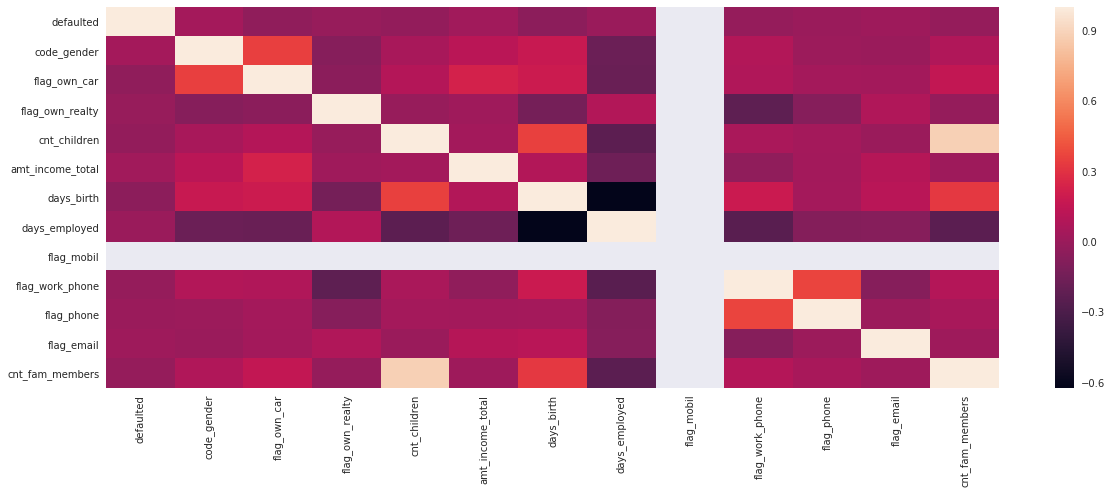

In [22]:
#check correlation between variables
sns.heatmap(result.corr())

In [26]:
#validate that flag_mobile is meaningless if everyone has a phone
result['flag_mobil'].nunique()

1

In [27]:
#drop the the mobile ownership variable
result.drop('flag_mobil', axis = 1, inplace=True)

In [29]:
#We now need to distinguish between 'traditional' and 'hybrid' variables for credit scoring
#The hybrid contains all variables to calculate the informational value-add of alternative data
traditional = ['defaulted',
 'code_gender',
 'amt_income_total',
 'days_birth',
 'days_employed',
 'name_income_type_Commercial associate',
 'name_income_type_Pensioner',
 'name_income_type_State servant',
 'name_income_type_Working']
hybrid = final.columns.to_list()

#we create two datasets to be used for model training to measure the difference in performance
final_hybrid = final
final_traditional = final[traditional]

In [30]:
#define a general function for exporting data to csv
def make_csv(x, y, filename, data_dir):
    '''Merges features and labels and converts them into one csv file with labels in the first column.
       :param x: Data features
       :param y: Data labels
       :param file_name: Name of csv file, ex. 'train.csv'
       :param data_dir: The directory where files will be saved
       '''
    # make data dir, if it does not exist
    if not os.path.exists(data_dir):
        os.makedirs(data_dir)
    
    # your code here
    
    values = np.column_stack((y, x))
    
    pd.DataFrame(values).to_csv(os.path.join(data_dir, filename), header=False, index=False)

In [36]:
#split data into train (67%), validation (11%), and test sets (22%) for both traditional and hybrid data

from sklearn.model_selection import train_test_split

#export hybrid data ensuring that label column is first
data_dir = 'hybrid_credit_data'
X = final_hybrid.drop('defaulted', axis=1)
y = final_hybrid['defaulted']
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X, y, test_size=0.33, random_state=42)
make_csv(y_train_hybrid, X_train_hybrid, filename='train.csv', data_dir=data_dir)
make_csv(y_test_hybrid[:round(0.3*len(y_test_hybrid))], X_test_hybrid[:round(0.3*len(X_test_hybrid))], filename='validation.csv', data_dir=data_dir)
pd.DataFrame(X_test_hybrid[round(0.3*len(X_test_hybrid)):]).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

#export traditional data ensuring that label column is first
data_dir = 'traditional_credit_data'
X = final_traditional.drop('defaulted', axis=1)
y = final_traditional['defaulted']
X_train_traditional, X_test_traditional, y_train_traditional, y_test_traditional = train_test_split(X, y, test_size=0.33, random_state=42)
make_csv(y_train_traditional, X_train_traditional, filename='train.csv', data_dir=data_dir)
make_csv(y_test_traditional[:round(0.3*len(y_test_traditional))], X_test_traditional[:round(0.3*len(X_test_traditional))], filename='validation.csv', data_dir=data_dir)
pd.DataFrame(X_test_traditional[round(0.3*len(X_test_traditional)):]).to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

#NB: we have already made sure that the labels column (defauled) is first, as required by SageMaker

# Set up AWS model infrastructure

In [37]:
#imports for SageMaker
import boto3
import sagemaker

In [38]:
# session and role
sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

# create an S3 bucket
bucket = sagemaker_session.default_bucket()

In [39]:
#Uplad traditional data to S3
data_dir = 'traditional_credit_data'
prefix = 'traditional_credit_scoring'
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

#Upload hybrid data to S3
data_dir = 'hybrid_credit_data'
prefix = 'hybrid_credit_scoring'
input_data = sagemaker_session.upload_data(path=data_dir, bucket=bucket, key_prefix=prefix)
print(input_data)

s3://sagemaker-eu-central-1-303249258021/traditional_credit_scoring
s3://sagemaker-eu-central-1-303249258021/hybrid_credit_scoring


In [40]:
#check whether the data has been uploaded successfully
empty_check = []
for obj in boto3.resource('s3').Bucket(bucket).objects.all():
    empty_check.append(obj.key)
    print(obj.key)

assert len(empty_check) !=0, 'S3 bucket is empty.'
print('Test passed!')


hybrid_credit_scoring/test.csv
hybrid_credit_scoring/train.csv
hybrid_credit_scoring/validation.csv
traditional_credit_scoring/test.csv
traditional_credit_scoring/train.csv
traditional_credit_scoring/validation.csv
Test passed!


In [41]:
#Create predictions with traditional model and assess model performance
def model_assessment(data_dir, ground_truth):
    '''Function assesses model performance against ground truth data
        :param data_dir: data dictionary to retrieve predictions
        :param ground_truth: labels of test data set 
        '''
    
    predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
    predictions = [round(num) for num in predictions.squeeze().values]
    
    from sklearn.metrics import accuracy_score
    
    return accuracy_score(ground_truth, predictions)

# Train and assess traditional model 

In [42]:
#Define path
from sagemaker.amazon.amazon_estimator import get_image_uri
data_dir = 'traditional_credit_data'
prefix = 'traditional_credit_scoring'


#get xgb algorithm
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

#construct xgb estimator
xgb = sagemaker.estimator.Estimator(container, 
                                    role,                                   
                                    train_instance_count=1,                 
                                    train_instance_type='ml.m4.xlarge',     
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                    sagemaker_session=sagemaker_session)

#set xgb hyperparameters
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
validation_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

	get_image_uri(region, 'xgboost', '0.90-1').


2020-06-25 07:15:01 Starting - Starting the training job...
2020-06-25 07:15:02 Starting - Launching requested ML instances.........
2020-06-25 07:16:36 Starting - Preparing the instances for training...
2020-06-25 07:17:24 Downloading - Downloading input data...
2020-06-25 07:17:47 Training - Downloading the training image..Arguments: train
[2020-06-25:07:18:08:INFO] Running standalone xgboost training.
[2020-06-25:07:18:08:INFO] File size need to be processed in the node: 0.06mb. Available memory size in the node: 8473.86mb
[2020-06-25:07:18:08:INFO] Determined delimiter of CSV input is ','
[07:18:08] S3DistributionType set as FullyReplicated
[07:18:08] 1058x8 matrix with 8464 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-25:07:18:08:INFO] Determined delimiter of CSV input is ','
[07:18:08] S3DistributionType set as FullyReplicated
[07:18:08] 157x8 matrix with 1256 entries loaded from /opt/ml/input/data/validation?format=csv&label_column=

In [43]:
#deploy traditional model 
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

.....................Arguments: serve
Arguments: serve
[2020-06-25 07:22:08 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-06-25 07:22:08 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-06-25 07:22:08 +0000] [1] [INFO] Using worker: gevent
[2020-06-25 07:22:08 +0000] [38] [INFO] Booting worker with pid: 38
[2020-06-25 07:22:08 +0000] [39] [INFO] Booting worker with pid: 39
[2020-06-25 07:22:08 +0000] [40] [INFO] Booting worker with pid: 40
[2020-06-25 07:22:08 +0000] [41] [INFO] Booting worker with pid: 41
[2020-06-25:07:22:08:INFO] Model loaded successfully for worker : 38
[2020-06-25:07:22:08:INFO] Model loaded successfully for worker : 39
[2020-06-25:07:22:08:INFO] Model loaded successfully for worker : 40
[2020-06-25:07:22:08:INFO] Model loaded successfully for worker : 41
[2020-06-25 07:22:08 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-06-25 07:22:08 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-06-25 07:22:08 +0000] [1] [INFO] Using worker: ge

In [44]:
#Save data from S3 locally
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

#Assess model
print(model_assessment(data_dir=data_dir, ground_truth=y_test_traditional[round(0.3*len(X_test_traditional)):]))

#Store predictions
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
predictions_traditional = [round(num) for num in predictions.squeeze().values]

download: s3://sagemaker-eu-central-1-303249258021/xgboost-2020-06-25-07-18-43-196/test.csv.out to traditional_credit_data/test.csv.out
0.8904109589041096


# Train and assess hybrid model

In [45]:
#Define path
from sagemaker.amazon.amazon_estimator import get_image_uri
data_dir = 'hybrid_credit_data'
prefix = 'hybrid_credit_scoring'


#get xgb algorithm
container = get_image_uri(sagemaker_session.boto_region_name, 'xgboost')

#construct xgb estimator
xgb = sagemaker.estimator.Estimator(container, 
                                    role,                                   
                                    train_instance_count=1,                 
                                    train_instance_type='ml.m4.xlarge',     
                                    output_path='s3://{}/{}/output'.format(sagemaker_session.default_bucket(), prefix),
                                    sagemaker_session=sagemaker_session)

#set xgb hyperparameters
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        silent=0,
                        objective='binary:logistic',
                        early_stopping_rounds=10,
                        num_round=500)

train_location = sagemaker_session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)
validation_location = sagemaker_session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
test_location = sagemaker_session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)

s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=validation_location, content_type='csv')

xgb.fit({'train': s3_input_train, 'validation': s3_input_validation})

	get_image_uri(region, 'xgboost', '0.90-1').


2020-06-25 07:22:57 Starting - Starting the training job...
2020-06-25 07:22:59 Starting - Launching requested ML instances......
2020-06-25 07:24:05 Starting - Preparing the instances for training...
2020-06-25 07:24:49 Downloading - Downloading input data...
2020-06-25 07:25:23 Training - Training image download completed. Training in progress..Arguments: train
[2020-06-25:07:25:24:INFO] Running standalone xgboost training.
[2020-06-25:07:25:24:INFO] File size need to be processed in the node: 0.17mb. Available memory size in the node: 8491.05mb
[2020-06-25:07:25:24:INFO] Determined delimiter of CSV input is ','
[07:25:24] S3DistributionType set as FullyReplicated
[07:25:24] 1058x33 matrix with 34914 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[2020-06-25:07:25:24:INFO] Determined delimiter of CSV input is ','
[07:25:24] S3DistributionType set as FullyReplicated
[07:25:24] 157x33 matrix with 5181 entries loaded from /opt/ml/input/data/validation

In [46]:
#deploy hybrid model
xgb_transformer = xgb.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')
xgb_transformer.wait()

......................Arguments: serve
[2020-06-25 07:29:29 +0000] [1] [INFO] Starting gunicorn 19.7.1
[2020-06-25 07:29:29 +0000] [1] [INFO] Listening at: http://0.0.0.0:8080 (1)
[2020-06-25 07:29:29 +0000] [1] [INFO] Using worker: gevent
[2020-06-25 07:29:29 +0000] [38] [INFO] Booting worker with pid: 38
[2020-06-25 07:29:29 +0000] [39] [INFO] Booting worker with pid: 39
[2020-06-25 07:29:29 +0000] [40] [INFO] Booting worker with pid: 40
[2020-06-25 07:29:29 +0000] [41] [INFO] Booting worker with pid: 41
[2020-06-25:07:29:29:INFO] Model loaded successfully for worker : 38
[2020-06-25:07:29:29:INFO] Model loaded successfully for worker : 39
[2020-06-25:07:29:29:INFO] Model loaded successfully for worker : 40
[2020-06-25:07:29:29:INFO] Model loaded successfully for worker : 41
2020-06-25T07:29:49.632:[sagemaker logs]: MaxConcurrentTransforms=4, MaxPayloadInMB=6, BatchStrategy=MULTI_RECORD
[2020-06-25:07:29:49:INFO] Sniff delimiter as ','
[2020-06-25:07:29:49:INFO] Determined delimiter 

In [47]:
#Save data from S3 locally
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

#Assess model
print(model_assessment(data_dir=data_dir, ground_truth=y_test_hybrid[round(0.3*len(y_test_hybrid)):]))

#Store predictions
predictions = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)
predictions_hybrid = [round(num) for num in predictions.squeeze().values]

download: s3://sagemaker-eu-central-1-303249258021/xgboost-2020-06-25-07-26-09-457/test.csv.out to hybrid_credit_data/test.csv.out
0.6657534246575343


# Compare models and calculate value-add of alternative data

According to research by Oliver Wyman, a leading management consulting company, in their paper on [‘Alternative Data and the Unbanked’](https://www.oliverwyman.com/content/dam/oliver-wyman/v2/publications/2017/may/Alternative_Data_And_The_Unbanked.pdf) the cut-off rate for obtaining loans currently is at around 4% bad-rate. If we think that a ‘positive’ is someone who is lendable and a ‘negative’ is someone who is non-lendable, the banks essentially accept a false positive rate of 4%. Hence we can formulate the following optimization problem: maximize the number of true positives subject to the false postive rate being below 4%. 

However, we run into the issue that the traditional model is 'cheating'. Checking its predictions we realize that it takes advantage of the unbalanced dataset and maximizes accuracy by simply predicting that every applicant will not default, thereby reaching an accuracy of around 90% (i.e. the share of applicants who don't default). With this is does better than the hybrid model, but in practice it would be useless for a bank, since it does not help to distinguish between good and bad applicants. So we can note here a first if tentative win for the alternative data model - in some cases alternative data will be the only way to make any statistical inference about applicants if the availability of traditional data is sufficiently constrained.

Having reviewed [AWS xgb documentation](https://github.com/dmlc/xgboost/blob/master/doc/parameter.rst) to find another eval_metric (default is accuracy for binary classification) that would have the algorithm focus more on the defaulted applicants, I couldn't find anything that would make the xgb based on traditional data deviate from its 'cheating' strategy. Hence, I now balance the dataset 50/50 to compare performance between the traditional and hybrid model and do the ROC analysis. 

In [48]:
print('Number of people predicted to default based on traditional data is '+ str(predictions_traditional.count(1)))
print('Number of people predicted to default based on hybrid data is '+ str(predictions_hybrid.count(1)))

Number of people predicted to default based on traditional data is 0
Number of people predicted to default based on hybrid data is 118


In [49]:
#create balanced dataset
final_balanced = final.loc[final['defaulted']==0].sample(195).append(final.loc[final['defaulted'] != 0])

#devide into hybrid and traditional data
final_hybrid = final_balanced
final_traditional = final_balanced[traditional]

In [50]:
#split data into train (70%) and test sets (30%) for both traditional and hybrid data

#export hybrid data ensuring that label column is first
data_dir = 'hybrid_credit_data_balanced'
X = final_hybrid.drop('defaulted', axis=1)
y = final_hybrid['defaulted']
X_train_hybrid, X_test_hybrid, y_train_hybrid, y_test_hybrid = train_test_split(X, y, test_size=0.3, random_state=42)

#export traditional data ensuring that label column is first
data_dir = 'traditional_credit_data_balanced'
X = final_traditional.drop('defaulted', axis=1)
y = final_traditional['defaulted']
X_train_traditional, X_test_traditional, y_train_traditional, y_test_traditional = train_test_split(X, y, test_size=0.3, random_state=42)

#NB: we have already made sure that the labels column (defauled) is first, as required by SageMaker

In [58]:
#Test hybrid model
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

dtree = RandomForestClassifier(random_state=0)
dtree.fit(X_train_hybrid, y_train_hybrid)
predictions = dtree.predict(X_test_hybrid)

#Import model evaluation metrics and print evaluation results
print(classification_report(y_test_hybrid,predictions))
print(confusion_matrix(y_test_hybrid,predictions))

              precision    recall  f1-score   support

           0       0.62      0.63      0.62        62
           1       0.54      0.53      0.53        51

   micro avg       0.58      0.58      0.58       113
   macro avg       0.58      0.58      0.58       113
weighted avg       0.58      0.58      0.58       113

[[39 23]
 [24 27]]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [52]:
#test traditional model
dtree = RandomForestClassifier(random_state=0)
dtree.fit(X_train_traditional, y_train_traditional)
predictions = dtree.predict(X_test_traditional)

#Import model evaluation metrics and print evaluation results
print(classification_report(y_test_traditional,predictions))
print(confusion_matrix(y_test_traditional,predictions))

              precision    recall  f1-score   support

           0       0.68      0.61      0.64        62
           1       0.58      0.65      0.61        51

   micro avg       0.63      0.63      0.63       113
   macro avg       0.63      0.63      0.63       113
weighted avg       0.63      0.63      0.63       113

[[38 24]
 [18 33]]


/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


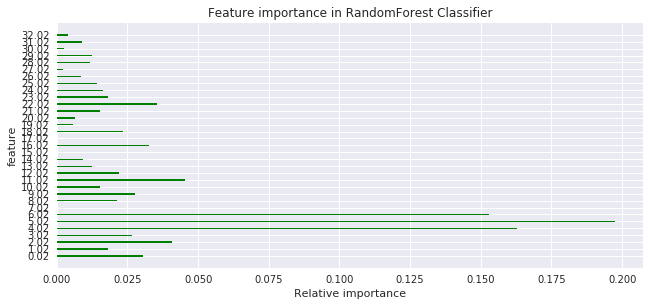

<Figure size 720x360 with 0 Axes>

In [74]:
#Visualize feature importance
col = [X_train_hybrid.columns.all()]
#modelname.feature_importance_
y = dtree.feature_importances_
#plot
fig, ax = plt.subplots() 
width = 0.2 # the width of the bars 
ind = np.arange(len(y)) # the x locations for the groups
ax.barh(ind, y, width, color='green')
ax.set_yticks(ind+width/10)
ax.set_yticklabels(col, minor=True)
plt.title('Feature importance in RandomForest Classifier')
plt.xlabel('Relative importance')
plt.ylabel('feature') 
plt.figure(figsize=(10,5))
fig.set_size_inches(10.5, 4.5)

In [84]:
#get feature dictionary
df_features = pd.DataFrame()
L = X_test_hybrid.columns
df_features['Features'] = L
df_features

,Features
0,code_gender
1,flag_own_car
2,flag_own_realty
3,cnt_children
4,amt_income_total
5,days_birth
6,days_employed
7,flag_mobil
8,flag_work_phone
9,flag_phone
